# Dynamic Knowledge Graph

This notebook introduces how to create a dynamic knowledge graph from a given text, instead of hardcode. It utilizes the spaCy to extract entities and relationships, and NetworkX for building and visualizing the graph. The main function showcases the entire workflow using a sample text about Albert Einstein.

## Import packages
We only use `spacy` and `networkx` for building the knowledge graph.

In [34]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import warnings

## Extract Entities with SpaCy
In this section, we will use spaCy to extract named entities from the input text. The `extract_entities` function takes a spaCy language model and a text string as input, and returns a list of extracted entities along with the processed document.

In [35]:

def load_nlp_model(model_name: str = 'en_core_web_sm'):
    """
    Load or download a spaCy language model.
    
    :param model_name: spaCy language model to use
    :return: Loaded spaCy language model
    """
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading {model_name} model...")
        spacy.cli.download(model_name)
        return spacy.load(model_name)

def extract_entities(nlp, text: str):
    """
    Extract named entities from the input text.
    
    :param nlp: spaCy language model
    :param text: Input text to analyze
    :return: List of extracted entities
    """
    doc = nlp(text)
    entities = list(doc.ents)
    
    # Print out entities for debugging
    print("Extracted Entities:")
    for ent in entities:
        print(f"{ent.text} - {ent.label_}")
    
    return entities, doc


## Build Knowledge Graph with NetworkX
In this section, we will build a knowledge graph using the extracted entities and relationships. The `build_knowledge_graph` function takes a list of entities and the original text as input, and returns a directed graph (DiGraph) using NetworkX. The graph nodes represent the entities, and the edges represent the relationships between them.

In [36]:
def build_knowledge_graph(entities, text: str):
    """
    Build a knowledge graph from extracted entities.
    
    :param entities: List of named entities
    :param text: Original input text
    :return: NetworkX DiGraph
    """
    # If no entities, return empty graph
    if not entities:
        print("No entities found in the text.")
        return nx.DiGraph()
    
    # Create graph
    graph = nx.DiGraph()
    
    # Use the first entity as the main entity
    main_entity = entities[0].text
    graph.add_node(main_entity, type=entities[0].label_)
    
    # Add all entities as nodes
    for ent in entities:
        graph.add_node(ent.text, type=ent.label_)
    
    # Add relationships between entities
    for ent in entities:
        if ent.text != main_entity:
            # Default relationship
            relation = "related_to"
            
            # More specific relationships based on entity type
            if ent.label_ == "GPE":
                relation = "located_in" if "in" in text.lower() else "associated_with"
            elif ent.label_ == "ORG":
                relation = "worked_at" if "position" in text.lower() else "associated_with"
            elif ent.label_ == "DATE":
                relation = "time_of_event"
            
            # Add edge from main entity to this entity
            graph.add_edge(main_entity, ent.text, relation=relation)
    
    return graph

The following funtion `add_dependency_relationships` adds a list of dependencies to the current object. This method takes a list of dependencies as an argument and does not return any value.

In [37]:
def add_dependency_relationships(graph, doc):
    """
    Add relationships based on dependency parsing.
    
    :param graph: NetworkX DiGraph
    :param doc: spaCy processed document
    :return: Updated graph
    """
    for sent in doc.sents:
        for token in sent:
            # Look for verb relationships
            if token.pos_ == 'VERB':
                subject = None
                obj = None
                
                # Find subject
                for child in token.children:
                    if child.dep_ in ['nsubj', 'nsubjpass']:
                        subject = child.text
                    elif child.dep_ in ['dobj', 'pobj', 'attr']:
                        obj = child.text
                
                # Add edge if both subject and object are in the graph
                if subject and obj and subject in graph.nodes and obj in graph.nodes:
                    graph.add_edge(subject, obj, relation=token.lemma_)
    
    return graph

## Visualize Knowledge Graph
The `visualize_knowledge_graph` function is responsible for generating a visual representation of the knowledge graph. The nodes represent entities, and the edges represent relationships between these entities.

In [42]:
def visualize_knowledge_graph(graph):
    """
    Visualize the knowledge graph.
    
    :param graph: NetworkX DiGraph to visualize
    :param output_file: File to save the graph visualization
    """
    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    
    plt.figure(figsize=(16, 12), dpi=300)
    
    # Use a more robust layout
    pos = nx.spring_layout(graph, k=0.9, iterations=50, seed=42)
    
    # Prepare node colors and sizes
    node_colors = []
    node_sizes = []
    for node in graph.nodes():
        node_type = graph.nodes[node].get('type', 'default')
        color_map = {
            'PERSON': 'skyblue',
            'ORG': 'lightgreen',
            'GPE': 'salmon',
            'DATE': 'lightpink',
            'default': 'lightgray'
        }
        node_colors.append(color_map.get(node_type, color_map['default']))
        
        # Larger size for the main entity (first entity)
        node_sizes.append(3000 if node == list(graph.nodes())[0] else 1000)
    
    # Draw the graph
    nx.draw(graph, pos, 
            with_labels=True, 
            node_color=node_colors,
            node_size=node_sizes, 
            font_size=10, 
            font_weight='bold',
            edge_color='gray',
            arrows=True,
            connectionstyle='arc3,rad=0.1')
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(graph, 'relation')
    nx.draw_networkx_edge_labels(graph, pos, 
                                 edge_labels=edge_labels,
                                 font_size=8,
                                 label_pos=0.5)
    
    plt.title("Dynamic Knowledge Graph", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout(pad=4)
    plt.show()
    
    plt.close()

The function `get_graph_statistics` provides detailed statistics about the knowledge graph, including counts of nodes, edges, and their types.

In [43]:
def get_graph_statistics(graph):
    """
    Get detailed statistics about the knowledge graph.
    
    :param graph: NetworkX DiGraph
    :return: Dictionary of graph statistics
    """
    node_types = {}
    for _, data in graph.nodes(data=True):
        node_type = data.get('type', 'Unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    edge_types = {}
    for _, _, data in graph.edges(data=True):
        rel_type = data.get('relation', 'Unknown')
        edge_types[rel_type] = edge_types.get(rel_type, 0) + 1
    
    return {
        'num_nodes': graph.number_of_nodes(),
        'num_edges': graph.number_of_edges(),
        'node_types': node_types,
        'edge_types': edge_types,
        'nodes': list(graph.nodes(data=True)),
        'edges': list(graph.edges(data=True))
    }

In [44]:
def create_knowledge_graph(text: str, model_name: str = 'en_core_web_sm'):
    """
    Main function to create a knowledge graph from input text.
    
    :param text: Input text to analyze
    :param model_name: spaCy language model to use
    :return: Completed knowledge graph
    """
    # Load NLP model
    nlp = load_nlp_model(model_name)
    
    # Extract entities
    entities, doc = extract_entities(nlp, text)
    
    if not entities:
        return None
    
    # Build initial graph
    graph = build_knowledge_graph(entities, text)
    
    # Add dependency-based relationships
    graph = add_dependency_relationships(graph, doc)
    
    return graph

Extracted Entities:
Albert Einstein - PERSON
the German Empire - GPE
Switzerland - GPE
1895 - DATE
Swiss - NORP
1903 - DATE
the Swiss Patent Office - ORG


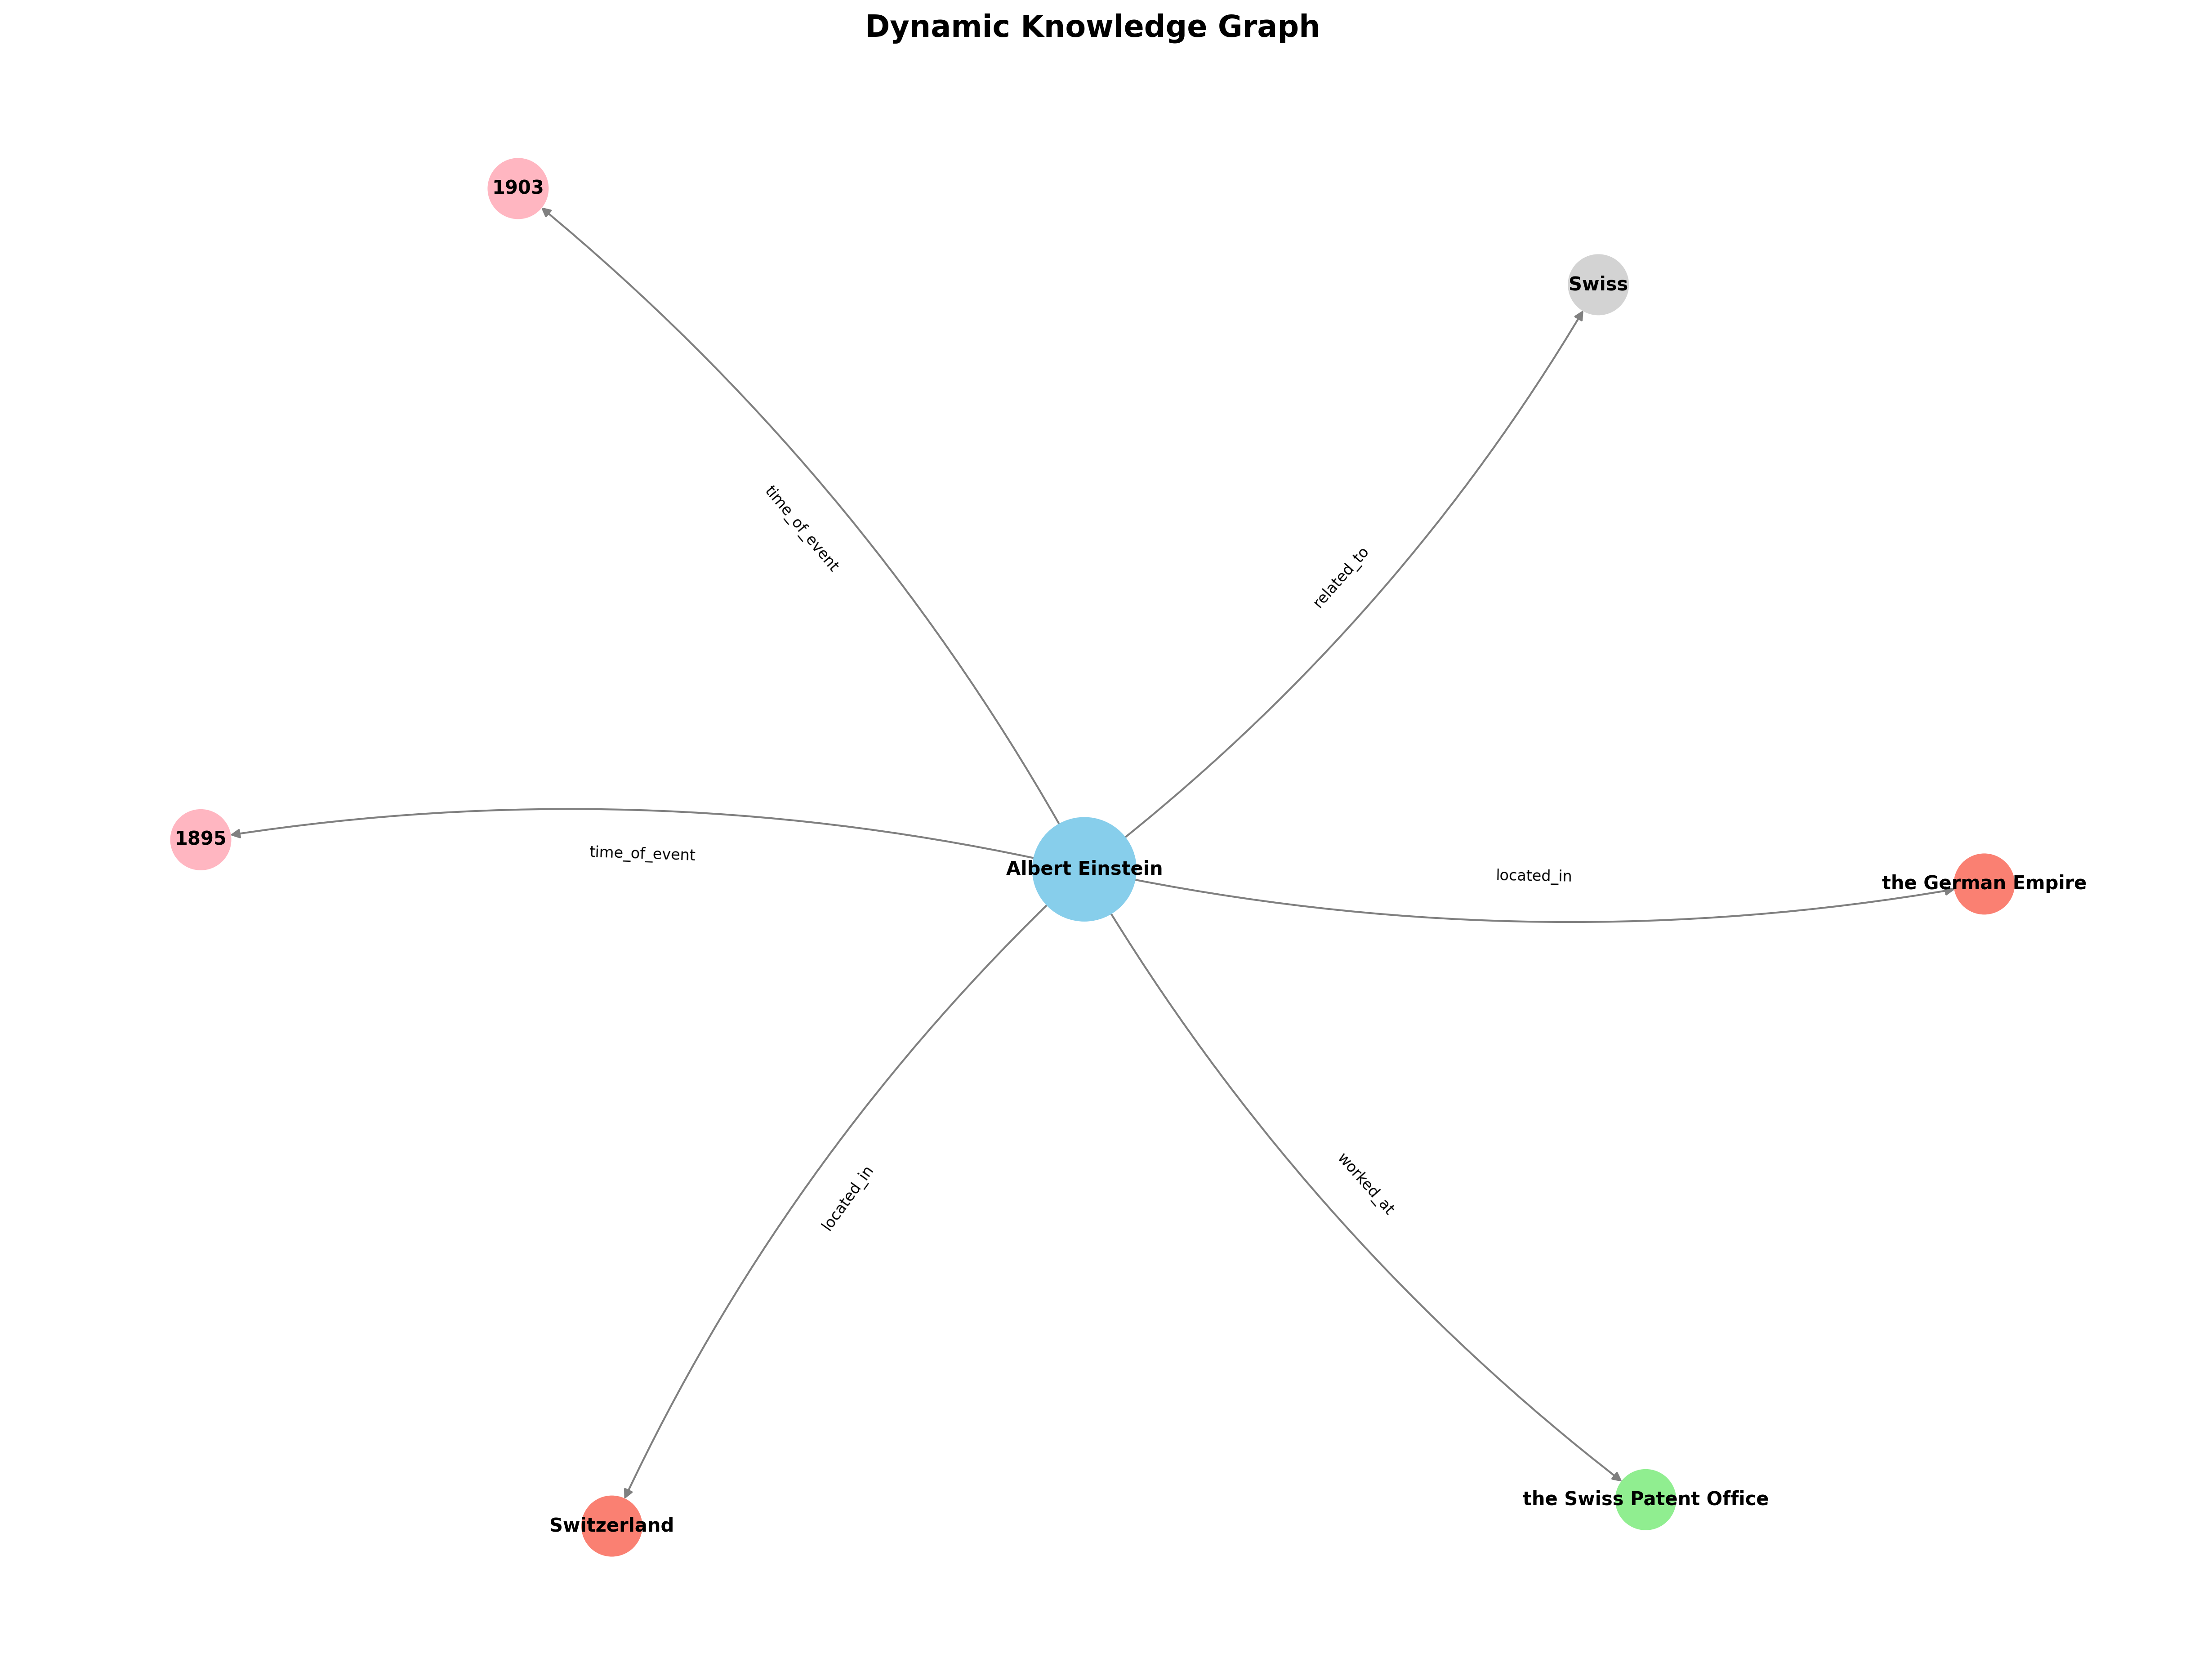


Graph Statistics:
Nodes: 7
Edges: 6

Node Types: {'PERSON': 1, 'GPE': 2, 'DATE': 2, 'NORP': 1, 'ORG': 1}

Edge Types: {'located_in': 2, 'time_of_event': 2, 'related_to': 1, 'worked_at': 1}


In [45]:
def main():
    # Sample text for knowledge graph creation
    sample_text = """
    Albert Einstein was a renowned physicist born in the German Empire. 
    He moved to Switzerland in 1895 and enrolled in the Swiss federal polytechnic school. 
    In 1903, he secured a permanent position at the Swiss Patent Office in Bern.
    """
    
    # Create knowledge graph
    graph = create_knowledge_graph(sample_text)
    
    if graph:
        # Visualize the graph
        visualize_knowledge_graph(graph)
        
        # Print graph statistics
        stats = get_graph_statistics(graph)
        print("\nGraph Statistics:")
        print(f"Nodes: {stats['num_nodes']}")
        print(f"Edges: {stats['num_edges']}")
        print("\nNode Types:", stats['node_types'])
        print("\nEdge Types:", stats['edge_types'])

if __name__ == "__main__":
    main()